In [2]:
!pip install openmeteo-requests
!pip install requests-cache retry-requests numpy pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.1 MB/s eta 0:00:00


In [3]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://air-quality-api.open-meteo.com/v1/air-quality"
params = {
	"latitude": 52.52,
	"longitude": 13.41,
	"hourly": ["pm10", "pm2_5"]
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_pm10 = hourly.Variables(0).ValuesAsNumpy()
hourly_pm2_5 = hourly.Variables(1).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["pm10"] = hourly_pm10
hourly_data["pm2_5"] = hourly_pm2_5

hourly_dataframe = pd.DataFrame(data = hourly_data)
print(hourly_dataframe)


Coordinates 52.54999542236328°N 13.450000762939453°E
Elevation 38.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
                         date       pm10  pm2_5
0   2024-04-11 00:00:00+00:00  13.300000    9.9
1   2024-04-11 01:00:00+00:00  13.300000   10.3
2   2024-04-11 02:00:00+00:00  14.000000   11.2
3   2024-04-11 03:00:00+00:00  15.700000   12.4
4   2024-04-11 04:00:00+00:00  16.200001   12.9
..                        ...        ...    ...
115 2024-04-15 19:00:00+00:00        NaN    NaN
116 2024-04-15 20:00:00+00:00        NaN    NaN
117 2024-04-15 21:00:00+00:00        NaN    NaN
118 2024-04-15 22:00:00+00:00        NaN    NaN
119 2024-04-15 23:00:00+00:00        NaN    NaN

[120 rows x 3 columns]


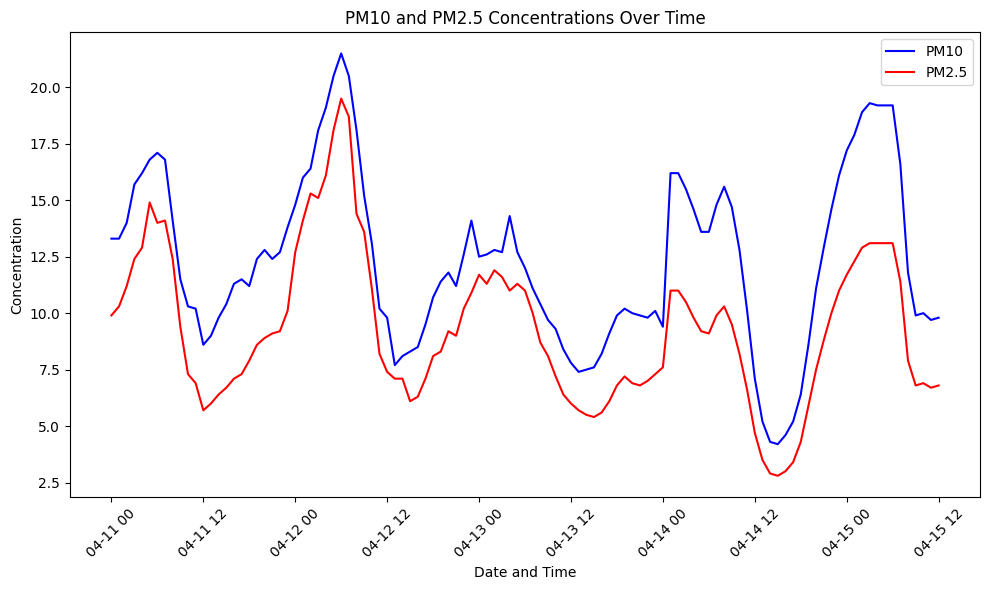

In [8]:
# Plotting
import matplotlib.pyplot as plt
# Convert the date column to datetime
df = hourly_dataframe.copy()
df['date'] = pd.to_datetime(df['date'])

# Set the date column as the index
df.set_index('date', inplace=True)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['pm10'], label='PM10', color='blue')
plt.plot(df.index, df['pm2_5'], label='PM2.5', color='red')
plt.xlabel('Date and Time')
plt.ylabel('Concentration')
plt.title('PM10 and PM2.5 Concentrations Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Show plot
plt.show()